# Wheeled cat-catching robot (i.e., the "catbot")

Import modules and configure the notebook.

In [1]:
# This module is part of the python standard library
import time

# These modules are part of other existing libraries
import numpy as np
import matplotlib.pyplot as plt
import ipywidgets as widgets
from IPython.display import display
import asyncio

# This is my own script (it is an interface to the pybullet simulator)
import ae353_catbot

Create an instance of the `Simulator` class, which is an interface to the [pybullet](http://pybullet.org) simulation engine.

There are several optional arguments:

* `display` (`True` or `False`) is whether or not to show the simulation window;
* `sound` (`True` or `False`) is whether or not to play sounds;
* `number_of_cats` (non-negative integer) is how many cats to launch.

If you want to test your controller with no cats, set `number_of_cats=0`.

In [2]:
simulator = ae353_catbot.Simulator(
    display=True,
    sound=True,
    number_of_cats=10,
)

You can open the visualizer by visiting the following URL:
http://127.0.0.1:7000/static/


Choose a camera view from the following options:
* `camera_sideview()`
* `camera_wideview()`
* `camera_topview()`
* `camera_catview()`

In [3]:
simulator.camera_sideview()

Define a controller that maps sensor measurements to actuator commands. By default, it chooses to apply zero torque to the wheels. Modify the `run` function to make the controller behave differently. This function will be called 100 times per second (i.e., at 100 Hz) by the simulator.

In [4]:
class Controller:
    def __init__(self):
        pass
    
    def reset(self):
        pass
    
    def run(
            self,
            t,
            wheel_position,
            wheel_velocity,
            pitch_angle,
            pitch_rate,
            cat_target,
        ):
        
        # FIXME: replace the following line
        
        # cat_target = 2.5 # use for testing

        des_parameter = 0.15

        if abs(cat_target-wheel_position) > des_parameter :
            wheel_position_des = wheel_position + des_parameter * abs(cat_target-wheel_position) / (cat_target-wheel_position)
        else:
            wheel_position_des = cat_target

        x = np.array([wheel_position-cat_target, pitch_angle, wheel_velocity, pitch_rate])
        x_des = np.array([wheel_position_des-cat_target, 0., 0., 0.])

        K = np.array([ -300 , -1000 , -100 , -200 ])
        
        u = -K@(x-x_des)

        wheel_torque = u
        
        return wheel_torque

Create an instance of the controller.

In [5]:
controller = Controller()

Reset the simulator with given initial conditions.

In [10]:
simulator.reset(
    initial_wheel_position=0.,
    initial_wheel_velocity=0.,
    initial_pitch_angle=0.,
    initial_pitch_rate=0.,
)

Reset the controller.

In [11]:
controller.reset()

Run the simulator.

A cat will launch after one second, and then every six seconds thereafter. So, you may want to choose `maximum_time` as follows:
* `maximum_time=6.99` if you want to catch one cat;
* `maximum_time=12.99` if you want to catch two cats;
* `maximum_time=18.99` if you want to catch three cats;
* ... and so forth.

In [13]:
data = simulator.run(
    controller,           # <-- required (an instance of your Controller class)
    maximum_time=6.99,    # <-- optional (how long you want to run the simulation in seconds)
    data_filename=None,   # <-- optional (save data to this file, e.g., 'my_data.json')
    video_filename=None,  # <-- optional (save video to this file, e.g., 'my_video.mov')
)

Count the number of saved cats.

In [14]:
number_of_cats_saved = simulator.get_number_of_cats_saved()
print(f'{number_of_cats_saved} cats were saved')

1 cats were saved


Get, show, and save a snapshot of the simulation after the last time step.

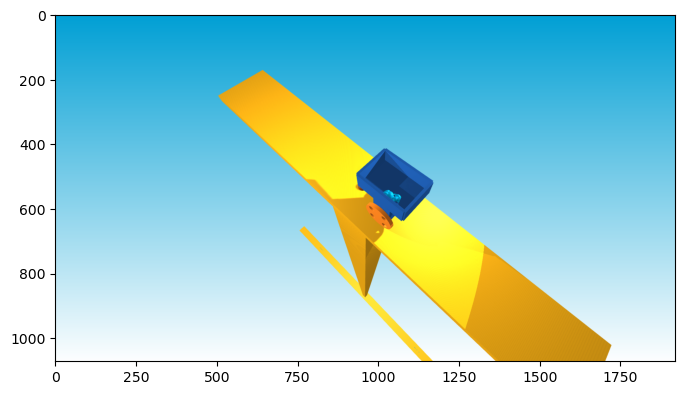

In [57]:
# Get snapshot as height x width x 4 numpy array of RGBA values
rgba = simulator.snapshot()

# Display snapshot
plt.figure(figsize=(8, 8))
plt.imshow(rgba)

# Save snapshot
plt.imsave('my_snapshot.png', rgba)

Plot the results.

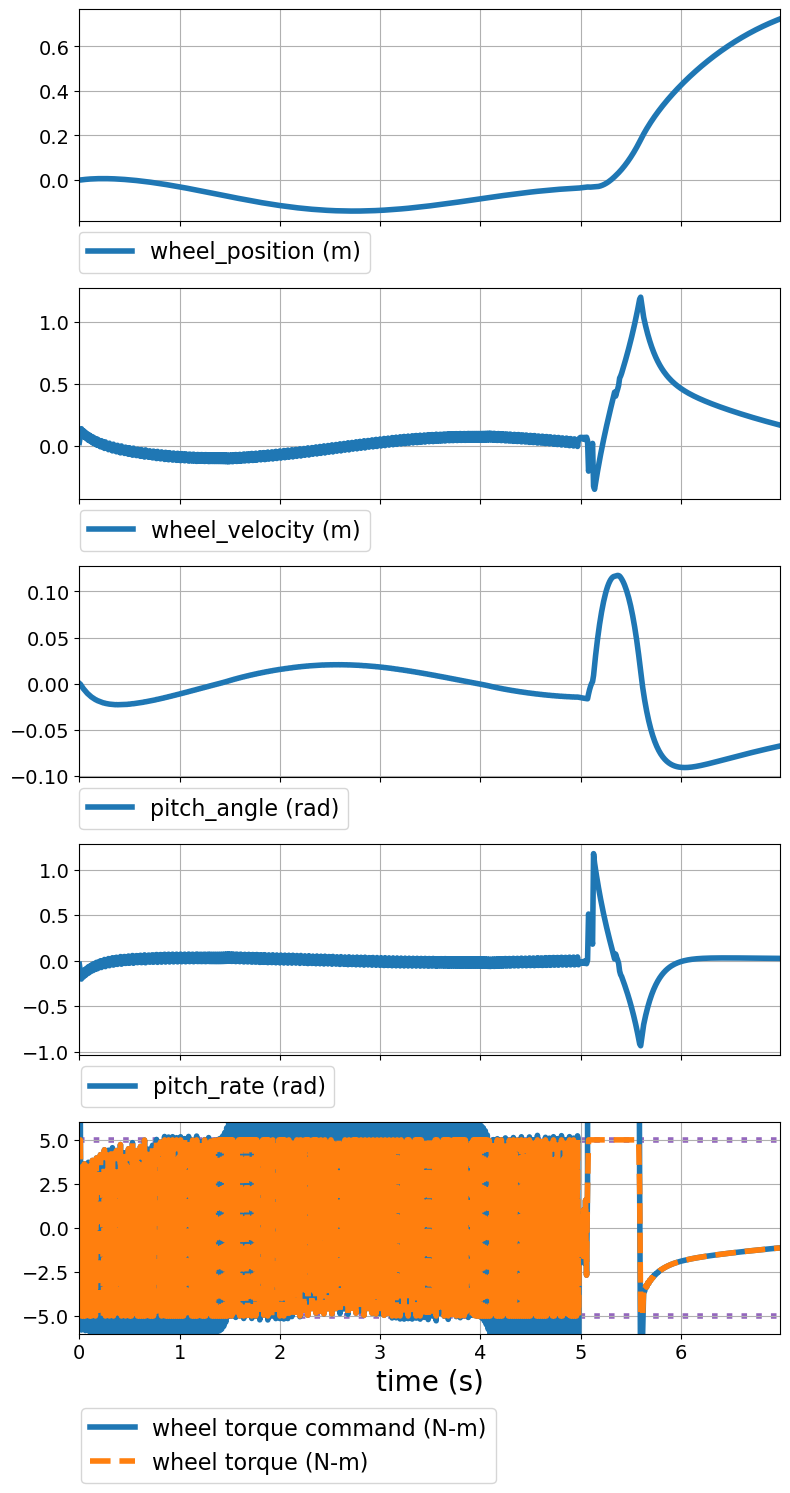

In [55]:
# Create a figure with five subplots, all of which share the same x-axis
fig, (
    ax_wheel_position,
    ax_wheel_velocity,
    ax_pitch_angle,
    ax_pitch_rate,
    ax_wheel_torque,
) = plt.subplots(5, 1, figsize=(8, 15), sharex=True)

# Plot wheel position
ax_wheel_position.plot(
    data['t'], data['wheel_position'],
    label='wheel_position (m)', linewidth=4,
)
ax_wheel_position.grid()
ax_wheel_position.legend(bbox_to_anchor=(0.43,-0.0),fontsize=16)
ax_wheel_position.tick_params(labelsize=14)

# Plot wheel velocity
ax_wheel_velocity.plot(
    data['t'], data['wheel_velocity'],
    label='wheel_velocity (m)', linewidth=4,
)
ax_wheel_velocity.grid()
ax_wheel_velocity.legend(bbox_to_anchor=(0.43,-0.0),fontsize=16)
ax_wheel_velocity.tick_params(labelsize=14)

# Plot pitch angle
ax_pitch_angle.plot(
    data['t'], data['pitch_angle'],
    label='pitch_angle (rad)', linewidth=4,
)
ax_pitch_angle.grid()
ax_pitch_angle.legend(bbox_to_anchor=(0.4,-0.0),fontsize=16)
ax_pitch_angle.tick_params(labelsize=14)

# Plot pitch rate
ax_pitch_rate.plot(
    data['t'], data['pitch_rate'],
    label='pitch_rate (rad)', linewidth=4,
)
ax_pitch_rate.grid()
ax_pitch_rate.legend(bbox_to_anchor=(0.38,-0.0),fontsize=16)
ax_pitch_rate.tick_params(labelsize=14)

# Plot wheel torque
ax_wheel_torque.plot(
    data['t'], data['wheel_torque_command'],
    label='wheel torque command (N-m)', linewidth=4,
)
ax_wheel_torque.plot(
    data['t'], data['wheel_torque'],
    '--', label='wheel torque (N-m)', linewidth=4,
)
ax_wheel_torque.plot(
    data['t'], -np.ones_like(data['t']) * simulator.maximum_wheel_torque,
    ':', linewidth=4, color='C4', zorder=0,
)
ax_wheel_torque.plot(
    data['t'], np.ones_like(data['t']) * simulator.maximum_wheel_torque,
    ':', linewidth=4, color='C4', zorder=0,
)
ax_wheel_torque.grid()
ax_wheel_torque.legend(bbox_to_anchor=(0.61,-0.3),fontsize=16)
ax_wheel_torque.tick_params(labelsize=14)
ax_wheel_torque.set_ylim(
    -1.2 * simulator.maximum_wheel_torque,
    1.2 * simulator.maximum_wheel_torque,
)

# Set x-axis properties (only need to do this on the last
# subplot since all subplots share the same x-axis)
ax_wheel_torque.set_xlabel('time (s)', fontsize=20)
ax_wheel_torque.set_xlim([data['t'][0], data['t'][-1]])

# Make the arrangement of subplots look nice
fig.tight_layout()

Save the figure (without transparent background).

In [56]:
fig.savefig('my_figure.png', facecolor='white', transparent=False)